## Initial Setup

In [26]:
import os
datapath = os.path.join("dataset", "home-credit-default-risk")

# Import and settings for plotings figures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


# Import panda
import pandas as pd
pd.set_option('display.max_columns', 500)

# Create a function to load the dataset into a panda object
def load_dataset(filename, path=datapath):
    csv_path = os.path.join(path, filename)
    return pd.read_csv(csv_path)

# Import numpy
import numpy as np

## Load Dataset

In [27]:
app_train = load_dataset("application_train.csv")
app_test = load_dataset("application_test.csv")
print("app_test shape: ", app_train.shape)
print("app_test shape: ", app_test.shape)

app_test shape:  (307511, 122)
app_test shape:  (48744, 121)


## Data Pre Processing

### Fixing anomalies

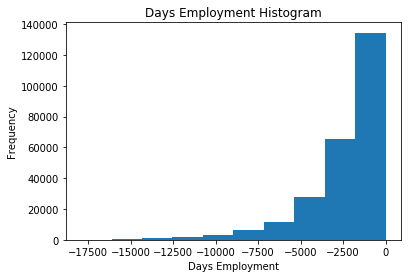

In [28]:
import numpy as np

app_train['DAYS_EMPLOYED_ANOM'] = (app_train["DAYS_EMPLOYED"] == 365243)


app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [29]:
app_test['DAYS_EMPLOYED_ANOM'] = (app_test['DAYS_EMPLOYED'] == 365243)
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

### Encoding

**Label encoding**

In [30]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            labelEncoder.fit(app_train[col])

            app_train[col] = labelEncoder.transform(app_train[col])
            app_test[col] = labelEncoder.transform(app_test[col])
            
            count += 1
            
print('%d columns were label encoded.' % count)

3 columns were label encoded.


**one-hot encoding**

In [31]:
print('before training shape: ', app_train.shape)
print('before test shape: ', app_test.shape)

# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('after training shape: ', app_train.shape)
print('after test shape: ', app_test.shape)


before training shape:  (307511, 123)
before test shape:  (48744, 122)
after training shape:  (307511, 244)
after test shape:  (48744, 240)


In [32]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dfs
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 241)
Testing Features shape:  (48744, 240)


## Polynomial Features

In [33]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                           'EXT_SOURCE_3', 'DAYS_BIRTH']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                               'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [34]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial training Features shape: ', poly_features.shape)
print('Polynomial test Features shape: ', poly_features_test.shape)

Polynomial training Features shape:  (307511, 35)
Polynomial test Features shape:  (48744, 35)


In [35]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 
                    'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [36]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
            columns = poly_transformer.get_feature_names([
                'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 
                'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = app_train['TARGET']

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
Name: TARGET, dtype: float64
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH    0.155891
EXT_SOURCE_2 DAYS_BIRTH                 0.156873
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.181283
TARGET                                  1.000000
1                                            NaN
Name: TARGET, dtype: float64


In [37]:
poly_features = pd.DataFrame(poly_features, 
            columns = poly_transformer.get_feature_names([
                'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 
                'DAYS_BIRTH']))

poly_features_test = pd.DataFrame(poly_features_test, 
        columns = poly_transformer.get_feature_names([
            'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train.shape)
print('Testing data with polynomial features shape:  ', app_test.shape)

Training data with polynomial features shape:  (307511, 276)
Testing data with polynomial features shape:   (48744, 275)


In [38]:
# Save training target labels and ids
train_labels = app_train['TARGET']
train_ids = app_train['SK_ID_CURR']
test_ids = app_test['SK_ID_CURR']
app_train = app_train.drop(['TARGET', 'SK_ID_CURR'], axis = 1)
app_test = app_test.drop(['SK_ID_CURR'], axis = 1)

### Missing values and Features Scaling

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
])

In [40]:
train = pipeline.fit_transform(app_train)
test = pipeline.fit_transform(app_test)
print('Training Features shape: ', train.shape)
print('Test Features shape: ', test.shape)

Training Features shape:  (307511, 274)
Test Features shape:  (48744, 274)


## Modeling - Base Scenario

## Logistic Regression (Cross Validated)

In [41]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="liblinear", random_state=10)

In [42]:
from sklearn.model_selection import cross_val_predict

labels_prob_lr = cross_val_predict(log_reg, train, train_labels, cv=6, 
                                method="predict_proba")

**ROC Curve**

In [43]:
from sklearn.metrics import roc_curve

In [44]:
from sklearn.metrics import roc_curve
# TPR: True Positive Rate
# FPR: False Positive Rate
fpr_lr, tpr_lr, thresholds_lr = roc_curve(train_labels, labels_prob_lr[:,1])

In [45]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

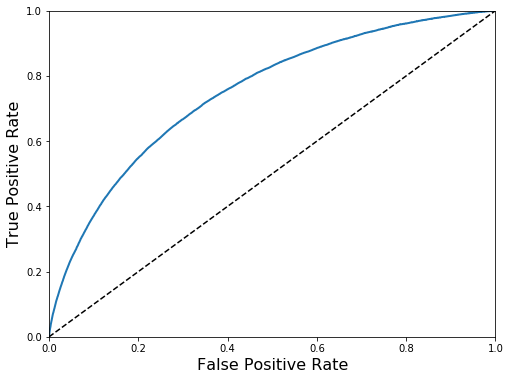

In [46]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_lr, tpr_lr)
plt.show()

**Calculate AUC**

In [47]:
from sklearn.metrics import roc_auc_score
roc_auc_score(train_labels, labels_prob_lr[:,1])

0.7492721230468768

**Save metrics**

In [48]:
metrics_names = list(['fpr', 'tpr', 'thresholds'])
metrics_lr = np.c_[fpr_lr, tpr_lr, thresholds_lr]
metrics_lr = pd.DataFrame(metrics_lr, columns=metrics_names)
metrics_lr.to_csv('metrics_lr_fe.csv')

label_names = list(['orig', 'prob'])
labels_lr = np.c_[train_labels, labels_prob_lr[:,1]]
labels_lr = pd.DataFrame(labels_lr, columns=label_names)
labels_lr.to_csv('labels_lr_fe.csv')

## Random Forest (Cross Validated)

In [49]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=256, 
                                n_jobs=-1, random_state=10)

In [50]:
from sklearn.model_selection import cross_val_predict

labels_prob_rf = cross_val_predict(rf_clf, train, train_labels, cv=6, 
                                   method="predict_proba")

**ROC Curve**

In [51]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(train_labels, labels_prob_rf[:,1])

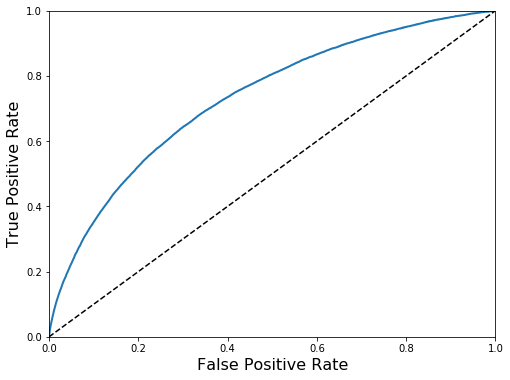

In [52]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_rf, tpr_rf)
plt.show()

**Calculate AUC**

In [53]:
roc_auc_score(train_labels, labels_prob_rf[:,1])

0.7321366019263958

**Save metrics**

In [54]:
metrics_names = list(['fpr', 'tpr', 'thresholds'])
metrics_rf = np.c_[fpr_rf, tpr_rf, thresholds_rf]
metrics_rf = pd.DataFrame(metrics_rf, columns=metrics_names)
metrics_rf.to_csv('metrics_rf_fe.csv')

label_names = list(['orig', 'prob'])
labels_rf = np.c_[train_labels, labels_prob_rf[:,1]]
labels_rf = pd.DataFrame(labels_rf, columns=label_names)
labels_rf.to_csv('labels_rf_fe.csv')

## Adaboost

In [55]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=250,
    algorithm="SAMME.R", learning_rate=0.5, random_state=10)

In [56]:
from sklearn.model_selection import cross_val_predict

labels_prob_ada = cross_val_predict(ada_clf, train, train_labels, cv=6, 
                                   method="predict_proba")

**ROC Curve**

In [57]:
fpr_ada, tpr_ada, thresholds_ada = roc_curve(
                    train_labels, labels_prob_ada[:,1])

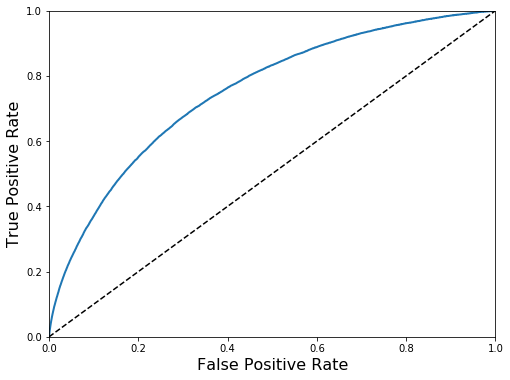

In [58]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_ada, tpr_ada)
plt.show()

**Calculate AUC**

In [59]:
roc_auc_score(train_labels, labels_prob_ada[:,1])

0.7518932570443029

**Save metrics**

In [60]:
metrics_names = list(['fpr', 'tpr', 'thresholds'])
metrics_ada = np.c_[fpr_ada, tpr_ada, thresholds_ada]
metrics_ada = pd.DataFrame(metrics_ada, columns=metrics_names)
metrics_ada.to_csv('metrics_ada_fe.csv')

label_names = list(['orig', 'prob'])
labels_ada = np.c_[train_labels, labels_prob_ada[:,1]]
labels_ada = pd.DataFrame(labels_ada, columns=label_names)
labels_ada.to_csv('labels_ada_fe.csv')

## Neural Network

**Split the training dataset into training and validation dataset**

In [61]:
X_valid, X_train = train[:50000], train[50000:]
y_valid, y_train = train_labels[:50000].values, train_labels[50000:].values

In [62]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [63]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

**Define network architecture parameters**

In [64]:
train_labels.shape

(307511,)

In [65]:
X_train.shape[1]

274

In [66]:
import tensorflow as tf

def reset_graph(seed=10):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

n_inputs = X_train.shape[1]  # number of features
n_hidden1 = 64
n_hidden2 = 64
n_hidden3 = 64
n_outputs = 2

In [67]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

**Buil the network with regularization**

In [68]:
scale = 0.001

In [69]:
from functools import partial
my_dense_layer = partial(
    tf.layers.dense, activation=leaky_relu,
    kernel_regularizer=tf.contrib.layers.l2_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    hidden3 = my_dense_layer(hidden2, n_hidden3, name="hidden3")
    logits = my_dense_layer(hidden3, n_outputs, activation=None,
                            name="outputs")
    y_proba = tf.nn.softmax(logits)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [70]:
with tf.name_scope("loss"):                                     
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  
        labels=y, logits=logits)                                
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

**Select the AdamOptimizer**

In [71]:
learning_rate = 0.001

with tf.name_scope("train"):
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
                                      
    training_op = optimizer.minimize(loss)

In [72]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [73]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

**Train the network**

In [74]:
n_epochs = 10
batch_size = 512

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, 
              "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./nn_base_fe_model.ckpt")

0 Batch accuracy: 0.88671875 Validation accuracy: 0.91948
1 Batch accuracy: 0.92578125 Validation accuracy: 0.91946
2 Batch accuracy: 0.9277344 Validation accuracy: 0.91948
3 Batch accuracy: 0.9003906 Validation accuracy: 0.91944
4 Batch accuracy: 0.9160156 Validation accuracy: 0.91944
5 Batch accuracy: 0.9121094 Validation accuracy: 0.91948
6 Batch accuracy: 0.94140625 Validation accuracy: 0.91948
7 Batch accuracy: 0.92578125 Validation accuracy: 0.91948
8 Batch accuracy: 0.9238281 Validation accuracy: 0.91948
9 Batch accuracy: 0.9199219 Validation accuracy: 0.91948


In [75]:
with tf.Session() as sess:
    saver.restore(sess, "./nn_base_fe_model.ckpt") 
    labels_prob_nn = y_proba.eval(feed_dict={X: X_valid})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./nn_base_fe_model.ckpt


**ROC curve**

In [76]:
fpr_nn, tpr_nn, thresholds_nn = roc_curve(
                    y_valid, labels_prob_nn[:,1])

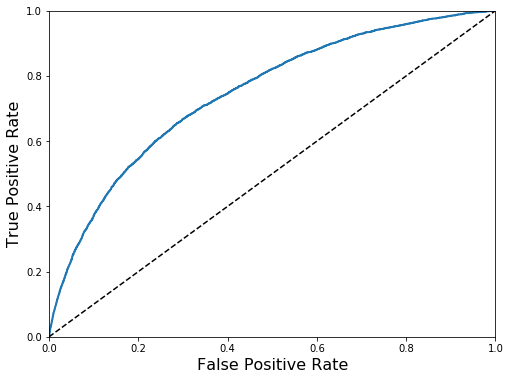

In [77]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_nn, tpr_nn)
plt.show()

**Calculate AUC**

In [78]:
roc_auc_score(y_valid, labels_prob_nn[:,1])

0.7464801375563126

**Save Metrics**

In [79]:
metrics_names = list(['fpr', 'tpr', 'thresholds'])
metrics_nn = np.c_[fpr_nn, tpr_nn, thresholds_nn]
metrics_nn = pd.DataFrame(metrics_nn, columns=metrics_names)
metrics_nn.to_csv('metrics_nn_fe.csv')

label_names = list(['orig', 'prob'])
labels_nn = np.c_[y_valid, labels_prob_nn[:,1]]
labels_nn = pd.DataFrame(labels_nn, columns=label_names)
labels_nn.to_csv('labels_nn_fe.csv')